# CDS Par Spread Returns Construction

## Paper Introduction

This construction is based upon the structure proposed by Siriwardane, Sunderam, and Wallen in Segmented Arbitrage (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3960980). The original paper studies the concept of implied arbitrage returns in many different markets. If markets were truly frictionless, we would expect there to be perfect correlation between all of the arbitrage returns. This is because efficient capital allocation would dictate that capital be spent where the best opportunity is, thus dictating the arbitrage opportunites we calculate via different product would have correlating rates as capital would be allocated to a different source if the arbitrage opportunity looks more attractive.

## CDS Par Spread Returns

### Spread Construction

In the following notebook, we will walk through the steps to constructing the implied arbitrage found in the CDS and corporate bond market as specified in the Appendix of the paper (https://static1.squarespace.com/static/5e29e11bb83a3f5d75beb17d/t/654d74d916f20316049a0889/1699575002123/Appendix.pdf). The authors define the CDS basis ($CB$) as

$$
CB_{i, t, \tau} = CDS_{i, t, \tau} - FR_{i, t, \tau}
$$

where:
- $FR_{i, t, \tau}$ = time $t$ floating rate spread implied by a fixed-rate corporate bond issued by firm $i$ at tenor $\tau$
- $CDS_{i, t, \tau}$ = time $t$ Credit Default Swap (CDS) par spread for firm $i$ with tenor $\tau$

A negative basis implies an investor could earn a positive arbitrage profit by going long the bond and purchasing CDS protection. The investor would pay a lower par spread than the coupon of the bond itself and then receive value from the default. 

The value of $FR$ is substituted by the paper with **Z-spread** which we also modify in our construction. We will go into the substitution in detail later. 

The value of $CDS$ is interpolated by the authors using a cubic spline function.

### Implied Risk Free Return

Given the CDS spread from above, traditional construction of a risk free rate for implied arbitrage implied the following return.

$$
rfr^{CDS}_{i, t, \tau} = y_{t, \tau} - CB_{i , t, \tau}
$$

where:
- $y_{t, \tau}$ = maturity matched treasury yield at time $t$

The risk free rate then can be seen as the treasury yield in addition to the basis recieved when executing the CDS basis trade (investor benefits from negative basis).



In [ ]:
import sys
from pathlib import Path

sys.path.insert(0, "../../src")

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import ctypes
from scipy.interpolate import CubicSpline

from NEW_MERGE_cds_bond import *
from process_final_product import *

# from he_kelly_manela import pull_he_kelly_manela
# from wrds_markit import pull_markit_cds, pull_fed_yield_curve
# from wrds_corp_bonds import pull_corp_bonds
# from settings import config

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# DATA_DIR = Path(config("DATA_DIR"))
DATA_DIR = "../../../FS-project_files"

RED_CODE_FILE_NAME = "RED_and_ISIN_mapping.parquet"
CORPORATES_MONTHLY_FILE_NAME = "corporate_bond_returns.parquet"
CDS_FILE_NAME = "cds_final.pkl" # CHANGE TO PARQUET WHEN DEPEDENCY IS SORTED

## Z-Spread (Zero-Volatility Spread)

**Mathematical definition**

For a bond with cash-flows $CF_t$ at times $t=1,\dots,N$ and Treasury spot rates $s_t$,

$$
P = \sum_{t=1}^{N} \frac{CF_t}{\bigl(1+s_t+Z\bigr)^t}.
$$

The constant $Z$ that solves this equation is the **Z-spread**.

**Intuition**

$Z$ is the uniform extra yield added to every point on the risk-free spot curve so that the discounted cash-flows equal the bond’s dirty price $P$. It compensates investors for credit and liquidity risk relative to Treasuries.


### Link to Yield-to-Maturity

Setting the Z-spread pricing equation equal to the standard YTM equation gives

$$

\sum_{t=1}^{N}\frac{CF_t}{(1+y)^t}
=\sum_{t=1}^{N}\frac{CF_t}{\bigl(1+s_t+Z\bigr)^t}
\tag{A1}
$$

where $y$ is the bond’s yield-to-maturity.  Except for the trivial flat-curve case ($s_t=s$), (A1) has no algebraic solution—$y$ or $Z$ must be found numerically.


### Continuous-Compounding Identity

Rewrite discounts as $e^{-r t}$.  With PV-weights

$$
w_t=\frac{CF_t\,e^{-(s_t+Z)t}}{P},\qquad\sum_{t}w_t=1,
$$

equation (A1) yields the convenient mean-value relationship

$$
y \;=\; \sum_{t=1}^{N} w_t\,(s_t+Z)\tag{A2}
$$

Thus YTM is the PV-weighted average of the spot rates plus the Z-spread.


### Practical Proxy: YTM Credit Spread

Analysts often approximate $Z$ with the **credit spread**

$$
\Delta y = y_{\text{bond}} - y_{\text{Treasury-DM}},
$$

where $y_{\text{Treasury-DM}}$ is the yield on a Treasury portfolio matched to the bond’s (modified) duration.

**Why it works**

1. A small parallel shift $Z$ applied to all discount rates changes price by $-D_{\text{mod}}\;Z$.  For modest spreads, this produces nearly the same price change as replacing the spot curve with a single rate shift $\Delta y$.  
2. Duration-matching the Treasury benchmark neutralises curve-shape effects, so $\Delta y$ isolates the average extra yield attributable to credit/liquidity risk.  
3. Empirically, $\Delta y$ tracks $Z$ closely for plain-vanilla, option-free bonds, making it a “good-enough” proxy when full spot-curve data or iterative Z-spread calculations are impractical.



## Data Overview

In [69]:
corp_bonds_data = pd.read_parquet(f"{DATA_DIR}/{CORPORATES_MONTHLY_FILE_NAME}")
red_data = pd.read_parquet(f"{DATA_DIR}/{RED_CODE_FILE_NAME}")
cds_data = pd.read_pickle(f"{DATA_DIR}/{CDS_FILE_NAME}")

In [70]:
corp_bonds_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572384 entries, 0 to 1572383
Data columns (total 49 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   date             1572384 non-null  datetime64[ns]
 1   cusip            1572384 non-null  object        
 2   issuer_cusip     1572384 non-null  object        
 3   permno           1422169 non-null  float64       
 4   exretn_t+1       1041541 non-null  float64       
 5   exretnc_bns_t+1  1030933 non-null  float64       
 6   exretnc_t+1      1038056 non-null  float64       
 7   exretnc_dur_t+1  1038056 non-null  float64       
 8   bond_ret_t+1     1041541 non-null  float64       
 9   bond_ret         1046059 non-null  float64       
 10  exretn           1046059 non-null  float64       
 11  exretnc_bns      1035383 non-null  float64       
 12  exretnc          1042538 non-null  float64       
 13  exretnc_dur      1042538 non-null  float64       
 14  ra

As a proxy for the Z-spread, we will use the credit spread between the bond's yield and the yield on a Treasury portfolio matched to the bond's (modified) duration. In this data,

 - "cs" is the market-microstructure-noise-biased credit spread
 - "CS" is the credit spread that has been adjusted for the market-microstructure noise. We will use this as our proxy for the Z-spread.
 - "BOND_YIELD" is the corporate bond yield that has been adjusted for market-microstructure noise. We will use "BOND_YIELD" - "CS" as our treasury yield during the period.

In [71]:
corp_bonds_data.describe()

,date,permno,exretn_t+1,exretnc_bns_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_bns,...,BONDPRC,PRFULL,DURATION,CONVEXITY,CS_6M_DELTA,bond_value,BOND_VALUE,coupon,principal_amt,bondpar_mil
count,1572384,1.422169e+06,1.041541e+06,1.030933e+06,1.038056e+06,1.038056e+06,1.041541e+06,1.046059e+06,1.046059e+06,1.035383e+06,...,1.294588e+06,1.294588e+06,1.294588e+06,1.294588e+06,1.084920e+06,1.188065e+06,1.294585e+06,1.572384e+06,1.572384e+06,1.398323e+06
mean,2013-03-05 13:07:44.259111936,5.166780e+04,3.282121e-03,2.130163e-03,2.326617e-03,2.529531e-03,4.099201e-03,4.168516e-03,3.349400e-03,2.137542e-03,...,1.050217e+02,1.063816e+02,6.507442e+00,8.344123e+01,-3.073578e-02,6.512686e+07,6.196192e+07,5.730033e+00,9.998092e+02,5.559556e+02
min,2002-08-31 00:00:00,1.002500e+04,-9.767108e-01,-9.788410e-01,-9.754962e-01,-9.750838e-01,-9.753108e-01,-9.753108e-01,-9.767108e-01,-9.788410e-01,...,1.000000e-04,1.009944e-01,5.683952e-03,1.021010e-04,-1.066395e+01,1.500000e+01,1.700000e+01,0.000000e+00,1.000000e+01,1.000000e-03
25%,2007-12-31 00:00:00,2.322900e+04,-6.494539e-03,-5.660667e-03,-6.013460e-03,-5.673846e-03,-5.630089e-03,-5.611824e-03,-6.479160e-03,-5.682974e-03,...,9.967818e+01,1.005404e+02,3.231727e+00,1.276730e+01,-2.339199e-01,2.726895e+07,2.593350e+07,4.200000e+00,1.000000e+03,2.386430e+02
50%,2013-07-31 00:00:00,5.627400e+04,2.460858e-03,1.367245e-03,1.515543e-03,1.514050e-03,3.312874e-03,3.337704e-03,2.483598e-03,1.364946e-03,...,1.042477e+02,1.055880e+02,5.275024e+00,3.381145e+01,-4.462923e-02,4.723913e+07,4.368532e+07,5.875000e+00,1.000000e+03,4.000000e+02
75%,2018-04-30 00:00:00,7.892700e+04,1.359472e-02,1.012049e-02,1.096072e-02,1.054284e-02,1.441620e-02,1.448506e-02,1.366403e-02,1.013573e-02,...,1.105670e+02,1.121482e+02,8.567085e+00,9.504011e+01,1.521478e-01,7.836473e+07,7.508250e+07,7.125000e+00,1.000000e+03,7.000000e+02
max,2022-09-30 00:00:00,9.343300e+04,3.683310e+00,3.679218e+00,1.093704e+00,1.026469e+00,3.683510e+00,3.683510e+00,3.683310e+00,3.679218e+00,...,8.491486e+03,8.491486e+03,3.546374e+01,1.346690e+03,7.585604e+00,1.899989e+09,1.908028e+09,1.650000e+01,1.000000e+03,1.500000e+04
std,NaN,2.817581e+04,4.198366e-02,4.125521e-02,4.183619e-02,4.056453e-02,4.193871e-02,4.217267e-02,4.221634e-02,4.147882e-02,...,1.604661e+01,1.615361e+01,4.342256e+00,1.118131e+02,4.059461e-01,6.674075e+07,6.490551e+07,2.133292e+00,1.374154e+01,5.971824e+02


# Step 1: Merge the Redcodes of firms on to the corporate bonds.

The code for it is in **NEW_MERGE_cds_bond.py** in the function **merge_redcode_into_bond_treas**. The more specific inputs are within the function itself.

Given CDS tables record issuers of the Credit Default Swaps using Redcode and the bond tables only had CUSIPs, we needed to merge a redcode-CUSIP matching table to the end product of step 1.2 for CDS merging later on.

We will pull the results without processing for CDS implied arbitrage returns.

In [72]:
corp_red_data = merge_red_code_into_bond_treas(corp_bonds_data, red_data)

In [73]:
corp_red_data.head()

,date,cusip,issuer_cusip,BOND_YIELD,CS,size_ig,size_jk,mat_days,redcode
0,2013-05-31,00101JAE6,00101J,0.021252,0.013751,1.0,1.0,1506.0,0A119O
1,2013-05-31,00101JAE6,00101J,0.021252,0.013751,1.0,1.0,1506.0,UU079R
2,2013-06-30,00101JAE6,00101J,0.026850,0.017144,1.0,1.0,1476.0,0A119O
3,2013-06-30,00101JAE6,00101J,0.026850,0.017144,1.0,1.0,1476.0,UU079R
4,2013-07-31,00101JAE6,00101J,0.023579,0.014047,1.0,1.0,1445.0,0A119O


In [74]:
corp_red_data.describe()

,date,BOND_YIELD,CS,size_ig,size_jk,mat_days
count,1390848,1.244620e+06,1.244620e+06,1.308426e+06,1.308426e+06,1.308426e+06
mean,2013-01-16 18:41:05.495581696,4.868466e-02,2.609838e-02,8.222727e-01,9.782716e-01,3.767596e+03
min,2002-08-31 00:00:00,-7.918977e-01,-8.427172e-01,0.000000e+00,0.000000e+00,3.610000e+02
25%,2008-01-31 00:00:00,2.912781e-02,9.949811e-03,1.000000e+00,1.000000e+00,1.346000e+03
50%,2013-03-31 00:00:00,4.340775e-02,1.700141e-02,1.000000e+00,1.000000e+00,2.480000e+03
75%,2017-12-31 00:00:00,5.793469e-02,2.853965e-02,1.000000e+00,1.000000e+00,5.541000e+03
max,2022-09-30 00:00:00,2.442612e+01,2.441472e+01,1.000000e+00,1.000000e+00,3.652500e+04
std,NaN,6.519538e-02,6.474564e-02,3.822832e-01,1.457954e-01,3.536960e+03


# Step 2: CDS data pull and CDS data processing

## Step 2.1: CDS data pull

The CDS data pull will be filtered using the redcodes from the above **bond_redcode_merged_data** dataframe, ensuring that only the firms that have corporate bond data are pulled from the CDS table. This data from Markit is daily.

## Step 2.2: CDS data processing

Let's first observe the data to see what we are working with:


In [75]:
cds_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52324311 entries, 0 to 52324310
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   date       datetime64[ns]
 1   ticker     object        
 2   redcode    object        
 3   parspread  float64       
 4   tenor      object        
 5   tier       object        
 6   country    object        
 7   year       int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 3.1+ GB


In [76]:
cds_data.describe()

,date,parspread,year
count,52324311,5.222794e+07,5.232431e+07
mean,2013-09-01 13:28:38.409028864,1.855701e-02,2.013168e+03
min,2002-01-01 00:00:00,1.603000e-05,2.002000e+03
25%,2009-03-04 00:00:00,3.545569e-03,2.009000e+03
50%,2013-11-21 00:00:00,7.633296e-03,2.013000e+03
75%,2018-02-26 00:00:00,1.663924e-02,2.018000e+03
max,2023-12-29 00:00:00,2.167465e+01,2.023000e+03
std,NaN,7.578530e-02,5.593926e+00


The CDS data has a flaw: the **tenor** is displayed as opposed to **maturity date** which would allow for more accurate cubic splines of the par spread. To approximate the correct number of days, we use tenor as is and annualize. 

For example, if the tenor is $3Y$, the number of days that we use to annualize is $3 \times 365 = 1095$. 

In our processing function **NEW_MERGE_cds_bond**, we grab the **redcode, date** tuples for which we can generate a good cubic spline function, filter the bond and treasury dataframe (output of step 1). 

Then, we use the days between the **maturity** and the **date** for each corporate bond as the input for the cubic spline function for par spread generation. Thus, we end up with the final dataframe with bond, treasury, and cds data all merged together.

In [77]:
final_data = merge_cds_into_bonds(corp_red_data, cds_data)

c:\Users\xuv14\Spring 2025 Projects\ftsfa\src\cds_bond_basis\NEW_MERGE_cds_bond.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lambda row: cubic_splines[(row['redcode'], row['date'])](row['mat_days']), axis=1
c:\Users\xuv14\Spring 2025 Projects\ftsfa\src\cds_bond_basis\NEW_MERGE_cds_bond.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\xuv14\Spring 2025 Projects\ftsfa\src\cds_bond_basis\NEW_MERGE_cds_bond.py:172: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map 

In [78]:
final_data.head()

,cusip,date,mat_days,BOND_YIELD,CS,size_ig,size_jk,par_spread
39,00101JAE6,2014-12-31,927.0,0.033902,0.025627,1.0,1.0,0.034591
45,00101JAE6,2015-03-31,837.0,0.026494,0.020114,1.0,1.0,0.017713
47,00101JAE6,2015-04-30,807.0,0.024420,0.018444,1.0,1.0,0.017103
51,00101JAE6,2015-06-30,746.0,0.026136,0.019872,1.0,1.0,0.016516
53,00101JAE6,2015-07-31,715.0,0.022742,0.015899,1.0,1.0,0.012640


# Step 3: Processing

Revisiting the original model:

$$
CB_{i, t, \tau} = CDS_{i, t, \tau} - FR_{i, t, \tau}
$$

where:
- $FR_{i, t, \tau}$ = time $t$ floating rate spread implied by a fixed-rate corporate bond issued by firm $i$ at tenor $\tau$
    - We use "CS" from the original corporate bonds table for this
- $CDS_{i, t, \tau}$ = time $t$ Credit Default Swap (CDS) par spread for firm $i$ with tenor $\tau$
    - CDS parspread is constructed using a Cubic Spline

$$
rfr^{CDS}_{i, t, \tau} = y_{t, \tau} - CB_{i , t, \tau}
$$

where:
- $y_{t, \tau}$ = maturity matched treasury yield at time $t$
    - this is constructed via the "BOND_YIELD" - "CS" in the original corporate bond table

We threw out some unreasonable data for the absolute rf values exceeding 1 (risk free annual return of 100%). 

In [79]:
processed_final_data = process_cb_spread(final_data)

c:\Users\xuv14\Spring 2025 Projects\ftsfa\src\cds_bond_basis\process_final_product.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_rating'] = (


In [80]:
processed_final_data.head()

,cusip,date,mat_days,BOND_YIELD,CS,size_ig,size_jk,par_spread,FR,CB,rfr,c_rating
39,00101JAE6,2014-12-31,927.0,0.033902,0.025627,1.0,1.0,0.034591,0.025627,0.008964,-0.000690,2
45,00101JAE6,2015-03-31,837.0,0.026494,0.020114,1.0,1.0,0.017713,0.020114,-0.002401,0.008781,2
47,00101JAE6,2015-04-30,807.0,0.024420,0.018444,1.0,1.0,0.017103,0.018444,-0.001340,0.007317,2
51,00101JAE6,2015-06-30,746.0,0.026136,0.019872,1.0,1.0,0.016516,0.019872,-0.003356,0.009620,2
53,00101JAE6,2015-07-31,715.0,0.022742,0.015899,1.0,1.0,0.012640,0.015899,-0.003259,0.010102,2


In [81]:
processed_final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 538257 entries, 39 to 1390361
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   cusip       538257 non-null  object        
 1   date        538257 non-null  datetime64[ns]
 2   mat_days    538257 non-null  float64       
 3   BOND_YIELD  538257 non-null  float64       
 4   CS          538257 non-null  float64       
 5   size_ig     538257 non-null  float64       
 6   size_jk     538257 non-null  float64       
 7   par_spread  538257 non-null  float64       
 8   FR          538257 non-null  float64       
 9   CB          538257 non-null  float64       
 10  rfr         538257 non-null  float64       
 11  c_rating    538257 non-null  int64         
dtypes: datetime64[ns](1), float64(9), int64(1), object(1)
memory usage: 53.4+ MB


In [82]:
processed_final_data.describe()

,date,mat_days,BOND_YIELD,CS,size_ig,size_jk,par_spread,FR,CB,rfr,c_rating
count,538257,538257.000000,538257.000000,538257.000000,538257.000000,538257.000000,538257.000000,538257.000000,538257.000000,538257.000000,538257.000000
mean,2013-10-06 13:33:55.871340544,3600.817611,0.044457,0.022456,0.854421,0.984385,0.021445,0.022456,-0.001010,0.023012,1.693226
min,2002-09-30 00:00:00,361.000000,-0.791898,-0.842717,0.000000,0.000000,-0.966884,-0.842717,-0.991566,-0.999862,0.000000
25%,2009-03-31 00:00:00,1278.000000,0.027159,0.009024,1.000000,1.000000,0.002615,0.009024,-0.011857,0.013305,2.000000
50%,2014-02-28 00:00:00,2352.000000,0.040795,0.015531,1.000000,1.000000,0.007140,0.015531,-0.004959,0.025269,2.000000
75%,2018-07-31 00:00:00,5145.000000,0.054748,0.025515,1.000000,1.000000,0.019245,0.025515,-0.001199,0.043555,2.000000
max,2022-09-30 00:00:00,36478.000000,5.665780,5.663980,1.000000,1.000000,5.728639,5.663980,1.043381,0.998775,2.000000
std,NaN,3203.490880,0.039977,0.038650,0.352684,0.123981,0.110326,0.038650,0.103480,0.103058,0.709805


# Step 4: Results

Below is a graph of 3 categories of bonds where certain ETFs may include both IG and Junk (HY) bonds.

Rating 0: Only junk bonds (HY)

Rating 1: Only IG bonds

Rating 2: Both IG and Junk bonds (HY) in the product

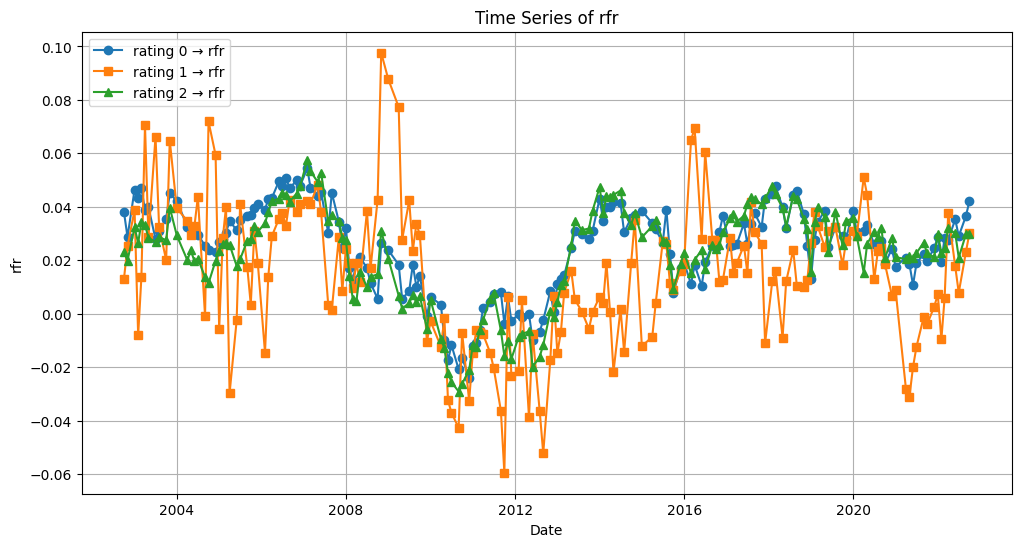

In [85]:
generate_graph(processed_final_data)